In [16]:
from PIL import Image
import cv2
import numpy as np
import picture_jiaozheng
from matplotlib import pyplot as plt

In [17]:
def sharpen_image(image):
    # 锐化滤波器的选择，可以做对比图
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [18]:
src = cv2.imread('D:\Data\GJY\Paper1\Paper-Rice\Paper1\Data_gjy\origin_img\\zhengmi5.jpg')
src_corrected = picture_jiaozheng.jiaozheng(src)

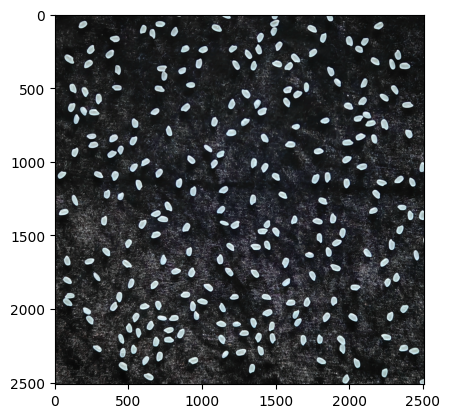

In [19]:
image=src_corrected

edge_margin = 280  # 可以根据需要调整，距离边缘50像素内的轮廓将被忽略
height, width = image.shape[:2]
# 假设要裁剪的区域是：
# 上边界y1, 下边界y2, 左边界x1, 右边界x2
y1, y2 = edge_margin, height - edge_margin  # 高度范围
x1, x2 = edge_margin, width - edge_margin  # 宽度范围

# 使用 NumPy 切片进行裁剪
cropped_image = image[y1:y2, x1:x2]


src = cropped_image.copy()
# cv2.imshow("src", src)
plt.imshow(src)
plt.show()

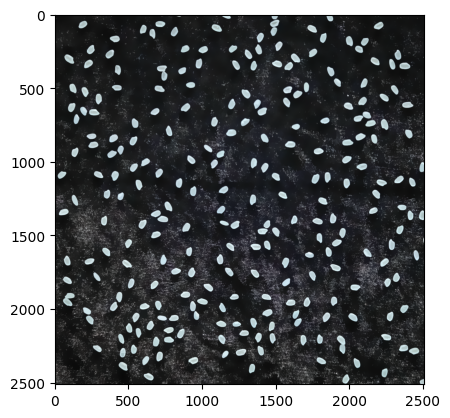

In [20]:
# 边缘保留滤波EPF 去噪，，新加调整sr的值
blur = cv2.pyrMeanShiftFiltering(cropped_image, sp=21, sr=20)
plt.imshow(blur)
plt.show()

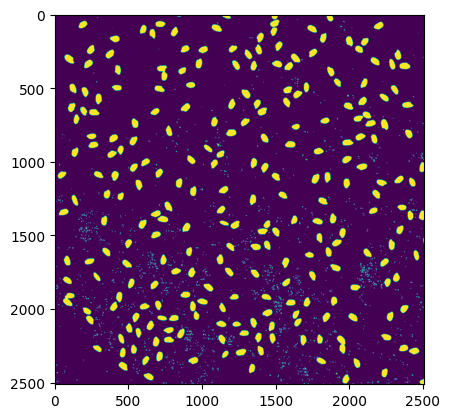

In [21]:
# 转成灰度图像
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
# 得到二值图像区间阈值
ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary)
plt.show()


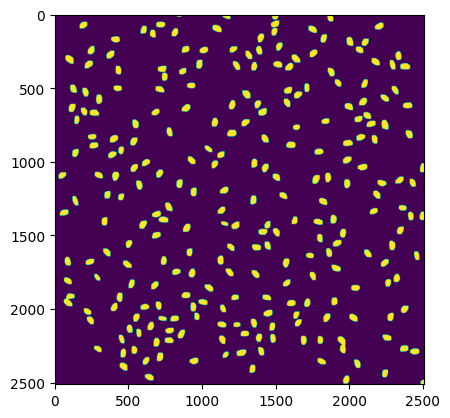

In [ ]:

# 形态学操作，细化物体边缘
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=5)
plt.imshow(binary)
plt.show()



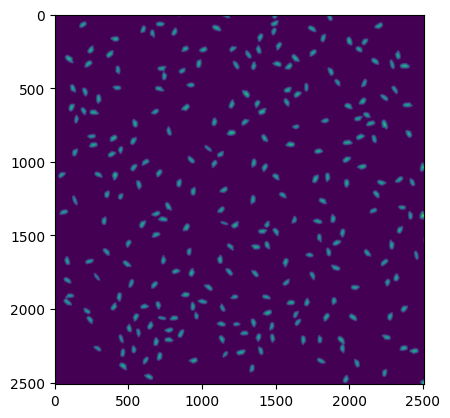

In [23]:
# 距离变换
dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
dist_out = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow(dist_out*100)
plt.show()



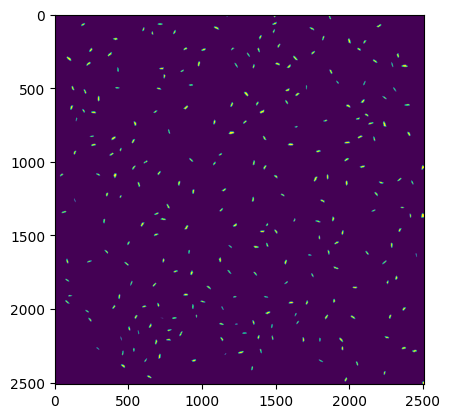

In [24]:
# 调整阈值以获得更精确的分割
ret, surface = cv2.threshold(dist_out, 0.5 * dist_out.max(), 255, cv2.THRESH_BINARY)
surface = np.uint8(surface)
plt.imshow(surface)
plt.show()



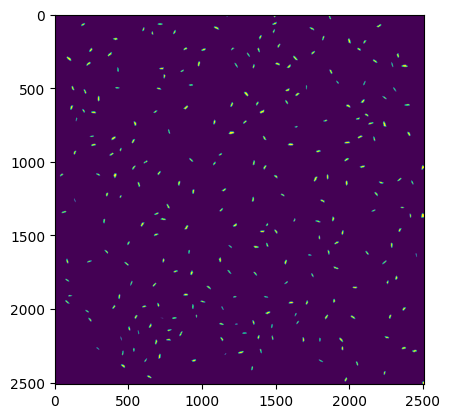

In [25]:
# 确定前景区域
sure_fg = surface
plt.imshow(sure_fg)
plt.show()


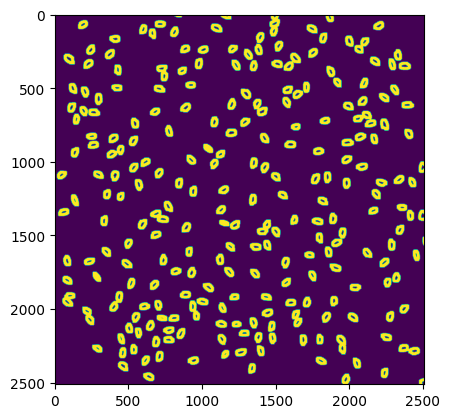

In [26]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

# 形态学操作来确定背景
sure_bg = cv2.dilate(binary, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown)
plt.show()



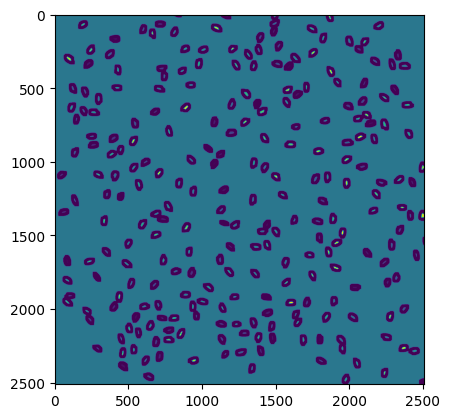

In [27]:
# 未知区域标记为0
markers[unknown == 255] = 0
markers_show = np.uint8(markers)
plt.imshow(markers_show*100)
plt.show()


In [28]:
# 分水岭算法分割
markers = cv2.watershed(cropped_image, markers)
cropped_image[markers == -1] = [255, 0, 0]


In [29]:
# 使用不同颜色标记分割的区域
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(markers)
markers_8u = np.uint8(markers)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (255, 128, 0), (255, 0, 128),
            (128, 255, 0), (128, 0, 255), (255, 128, 128), (128, 255, 255)]


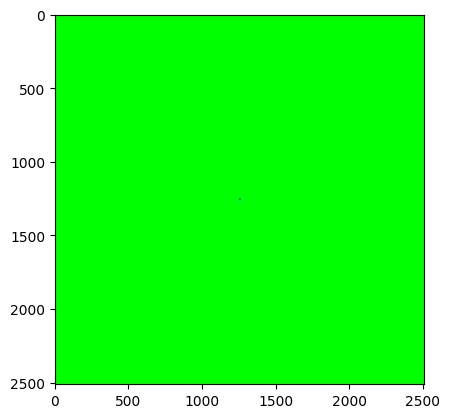

In [30]:
# 创建目录来保存分割后的物体
import os
save_dir = 'D:\Data\GJY\Paper1\Paper-Rice\Paper1\Data_gjy\Data\\train\\origin'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

object_count = 0  #原来是0
for i in range(2, int(max_val + 1)):
    ret, thres1 = cv2.threshold(markers_8u, i - 1, 255, cv2.THRESH_BINARY)
    ret2, thres2 = cv2.threshold(markers_8u, i, 255, cv2.THRESH_BINARY)
    mask = thres1 - thres2
    # cv2.imshow('mask', mask)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours:
        # 使用掩码提取单个目标物体
        mask_3ch = cv2.merge([mask, mask, mask])
        isolated_object = cv2.bitwise_and(src, mask_3ch)
        x, y, w, h = cv2.boundingRect(contours[0])
        segmented_object = isolated_object[y:y + h, x:x + w]
        cv2.imwrite(f"{save_dir}/{object_count}.png", segmented_object)
        object_count += 1

        cv2.drawContours(cropped_image, contours, -1, colors[(i - 2) % 12], -1)
        M = cv2.moments(contours[0])
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])  # 轮廓重心
            cv2.drawMarker(cropped_image, (cx, cy), (0, 0, 255), 1, 10, 2)
            cv2.drawMarker(src, (cx, cy), (0, 0, 255), 1, 10, 2)

cv2.putText(src, "count=%d" % (int(max_val - 1)), (220, 30), 0, 1, (0, 255, 0), 2)
cv2.putText(cropped_image, "count=%d" % (int(max_val - 1)), (220, 30), 0, 1, (0, 255, 0), 2)
# cv2.imshow('regions', cropped_image)
plt.imshow(cropped_image)
plt.show()